可视化风险价值

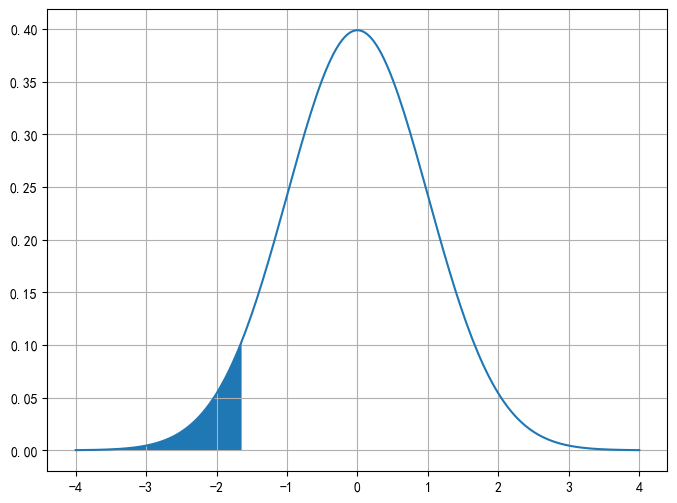

In [57]:
import numpy as np
import pandas as pd
import scipy.stats as st

'''
st.norm中的子模块
pdf:概率密度函数
cdf:累计概率分布函数
ppf:分位点函数,cdf的反函数
'''

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei'] #中文显示问题
plt.rcParams['axes.unicode_minus'] = False #负数显示问题


a = 0.95 #置信水平
z = st.norm.ppf(q=1-a) #返回q对应的分位点
x = np.linspace(-4,4,200) #组合的盈亏数组
y = st.norm.pdf(x) #组合盈亏对应的概率密度数组
x1 = np.linspace(-4,z,100) #组合最小亏损值与返回的分位点构成的盈亏数组
y1 = st.norm.pdf(x1)

plt.figure(figsize=(8,6))
plt.plot(x,y)
plt.fill_between(x1, y1)
plt.grid('True')


## VaR值的测度方法
### 方差-协方差法

In [58]:
data = pd.read_excel(r'投资组合配置的资产情况.xlsx',header = 0,index_col = 0)

#初始数据的归一化处理
R = np.log(data/data.shift(1))
#处理缺失数据
R = R.dropna() 

R_mean = R.mean() #计算均值
R_cov = R.cov() #计算协方差
R_corr = R.corr() #计算相关系数
R_vol = R.std() #计算标准差

# 方差协方差方法
def VaR_VCM(value,Rp,Vp,X,N):
    '''
    Parameters
    ----------
    value : 投资组合的价值
    Rp : 投资组合的日收益率
    Vp : 投资组合的日波动率
    X : 置信水平
    N : 持有天数
    
    '''
    import scipy.stats as st
    import numpy as np
    
    z = np.abs(st.norm.ppf(q=1-X))
    
    return np.sqrt(N)*value*(z*Vp-Rp)

weights = np.array([0.15,0.20,0.5,0.05,0.1])
#计算投资组合的期望收益率
Rp_daily = np.sum(weights*R_mean)
#计算投资组合的日波动率
Vp_daily = np.sqrt(np.dot(weights,np.dot(R_cov,weights.T)))

print('投资组合日收益率:',Rp_daily)
print('投资组合日波动率:',Vp_daily)

D1 = 1
D2 = 10
X1 = 0.99
X2 = 0.95
value_port = 100000000

VaR99_1day_VCM = VaR_VCM(value=value_port, Rp=Rp_daily, Vp=Vp_daily, X=X1, N=D1)
VaR99_10day_VCM = VaR_VCM(value=value_port, Rp=Rp_daily, Vp=Vp_daily, X=X1, N=D2)
VaR95_1day_VCM = VaR_VCM(value=value_port, Rp=Rp_daily, Vp=Vp_daily, X=X2, N=D1)
VaR95_10day_VCM = VaR_VCM(value=value_port, Rp=Rp_daily, Vp=Vp_daily, X=X2, N=D2)

print('1天、99%的VaR:',VaR99_1day_VCM)
print('10天、99%的VaR:',VaR99_10day_VCM)  
print('1天、95%的VaR:',VaR95_1day_VCM)
print('10天、99%的VaR:',VaR95_10day_VCM)  


投资组合日收益率: 0.00026827896370593585
投资组合日波动率: 0.006427216391102841
1天、99%的VaR: 1468366.2223736602
10天、99%的VaR: 4643381.701958061
1天、95%的VaR: 1030355.1228401522
10天、99%的VaR: 3258268.98699746


### 历史模拟法
历史模拟法：从当前回溯一定时期投资组合的历史盈亏，并把历史盈亏按照由大到小的顺序排列，从中找出符合给定置信水平的盈亏值。例如：1天、置信水平95%的VaR，把历史盈亏由大到小排列，VaR为95%的位置对应盈亏值的绝对值，或者由小到大排列，VaR为5%位置对应盈亏值的绝对值。

本文仍然使用上述案例数据进行说明，其Python程序如下：

In [59]:
#各资产配置
value_asset = value_port*weights
#历史交易日投资组合的盈亏值
Return_history = np.dot(R,value_asset)
Return_history = pd.DataFrame(Return_history,index=R.index,columns=['投资组合模拟日收益'])

#盈亏数据描述
Return_history.describe()
Return_history.plot()

#盈亏数据分布直方图
plt.hist(Return_history,bins=30)
plt.grid('True')

#投资组合盈亏值的正态性检验
#KS检验，返回统计量及P值
st.kstest(rvs=Return_history['投资组合模拟日收益'], cdf='norm')   
#AD检验，返回统计量、显著性水平对应的临界值（统计量）、显著性水平
st.anderson(x=Return_history['投资组合模拟日收益'], dist='norm')   
#返回统计量及P值
st.shapiro(Return_history['投资组合模拟日收益'])   
#返回统计量及P值
st.normaltest(Return_history['投资组合模拟日收益'])   


NormaltestResult(statistic=np.float64(192.37738470012985), pvalue=np.float64(1.6818284348842514e-42))

Error in callback <function _draw_all_if_interactive at 0x000002497D9C0400> (for post_execute), with arguments args (),kwargs {}:


ValueError: Date ordinal -4321800.852074206 converts to -9863-04-24T03:33:00.788608 (using epoch 1970-01-01T00:00:00), but Matplotlib dates must be between year 0001 and 9999.

ValueError: Date ordinal -4321800.852074206 converts to -9863-04-24T03:33:00.788608 (using epoch 1970-01-01T00:00:00), but Matplotlib dates must be between year 0001 and 9999.

<Figure size 640x480 with 1 Axes>

In [60]:
#计算历史模拟的VaR
VaR99_1day_history = np.abs(np.percentile(a=Return_history['投资组合模拟日收益'],q=(1-X1)*100))
VaR95_1day_history = np.abs(np.percentile(a=Return_history['投资组合模拟日收益'],q=(1-X2)*100))

VaR99_10day_history = np.sqrt(10)*VaR99_1day_history
VaR95_10day_history = np.sqrt(10)*VaR95_1day_history

print('1天、99%的VaR:',VaR99_1day_history)
print('10天、99%的VaR:',VaR99_10day_history)  
print('1天、95%的VaR:',VaR95_1day_history)
print('10天、99%的VaR:',VaR95_10day_history)  


1天、99%的VaR: 2135730.954515148
10天、99%的VaR: 6753774.285593342
1天、95%的VaR: 867143.3366165725
10天、99%的VaR: 2742148.0015464565


### 蒙特卡洛模拟法

1天、99%的VaR: 2041282.8959091322
10天、99%的VaR: 6455103.299817264
1天、95%的VaR: 1454931.6600935746
10天、95%的VaR: 4600897.885785605


C:\Users\admin\AppData\Local\Temp\ipykernel_19784\2044431647.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S1_new = S1*np.exp((R_mean[0]-0.5*R_vol[0]**2)*dt + R_vol[0]*epsilon*np.sqrt(dt))
C:\Users\admin\AppData\Local\Temp\ipykernel_19784\2044431647.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S2_new = S2*np.exp((R_mean[1]-0.5*R_vol[1]**2)*dt + R_vol[1]*epsilon*np.sqrt(dt))
C:\Users\admin\AppData\Local\Temp\ipykernel_19784\2044431647.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Data

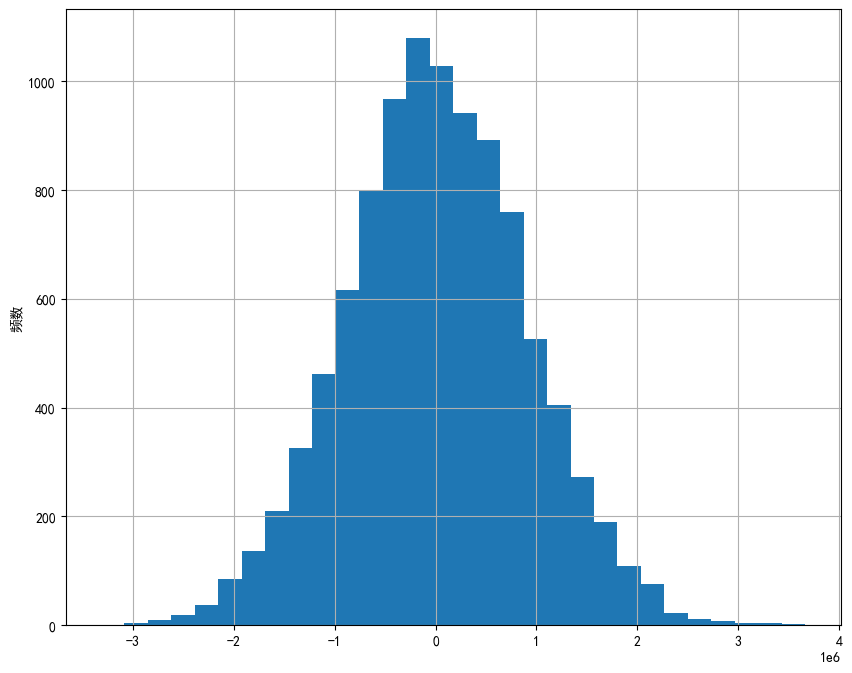

In [61]:
#蒙特卡洛模拟法
import numpy.random as npr 
I = 10000 #模拟次数
#从学生t分布进行I次模拟
epsilon = npr.standard_t(df=len(R),size=I)

#获取最新收盘价
S1 = data.iloc[-1,0]  #第一个资产的最新价格
S2 = data.iloc[-1,1]  
S3 = data.iloc[-1,2]  
S4 = data.iloc[-1,3]  
S5 = data.iloc[-1,4]  

R_mean = R.mean()*252 #投资组合各资产的年化收益
R_vol = R.std()*np.sqrt(252) #投资组合各资产的年化波动率
dt = 1/252 #年化单个交易日

#模拟投资组合下一个交易日各资产的收盘价
S1_new = S1*np.exp((R_mean[0]-0.5*R_vol[0]**2)*dt + R_vol[0]*epsilon*np.sqrt(dt))
S2_new = S2*np.exp((R_mean[1]-0.5*R_vol[1]**2)*dt + R_vol[1]*epsilon*np.sqrt(dt))
S3_new = S3*np.exp((R_mean[2]-0.5*R_vol[2]**2)*dt + R_vol[2]*epsilon*np.sqrt(dt))
S4_new = S4*np.exp((R_mean[3]-0.5*R_vol[3]**2)*dt + R_vol[3]*epsilon*np.sqrt(dt))
S5_new = S5*np.exp((R_mean[4]-0.5*R_vol[4]**2)*dt + R_vol[4]*epsilon*np.sqrt(dt))

#模拟投资组合下一个交易日各资产的盈亏
S1_delta = (S1_new/S1 - 1)*value_port*weights[0]
S2_delta = (S2_new/S2 - 1)*value_port*weights[1]
S3_delta = (S3_new/S3 - 1)*value_port*weights[2]
S4_delta = (S4_new/S4 - 1)*value_port*weights[3]
S5_delta = (S5_new/S5 - 1)*value_port*weights[4]
#计算投资组合下一个交易日的盈亏
Sp_delta = S1_delta + S2_delta + S3_delta + S4_delta + S5_delta

#下一交易日投资组合盈亏的可视化
plt.figure(figsize=(10,8))
plt.hist(Sp_delta,bins=30)
plt.ylabel('频数')
plt.grid(True)

#蒙特卡洛模拟法计算VaR
VaR99_1day_MS = np.abs(np.percentile(a=Sp_delta,q=(1-X1)*100))    
VaR95_1day_MS = np.abs(np.percentile(a=Sp_delta,q=(1-X2)*100))

VaR99_10day_MS = np.sqrt(10)*VaR99_1day_MS
VaR95_10day_MS = np.sqrt(10)*VaR95_1day_MS

#由于抽样随机数的原因，结果可能会有不同
print('1天、99%的VaR:',VaR99_1day_MS)
print('10天、99%的VaR:',VaR99_10day_MS)  
print('1天、95%的VaR:',VaR95_1day_MS)
print('10天、95%的VaR:',VaR95_10day_MS) 


1天、99%的VaR: 1965467.1061013269
10天、99%的VaR: 6215352.72142002
1天、95%的VaR: 1404420.466291185
10天、95%的VaR: 4441167.466035873


C:\Users\admin\AppData\Local\Temp\ipykernel_19784\3785637127.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S1_new = S1*np.exp((R_mean[0]-0.5*R_vol[0]**2)*dt + R_vol[0]*epsilon*np.sqrt(dt))
C:\Users\admin\AppData\Local\Temp\ipykernel_19784\3785637127.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S_new[:,i] = data.iloc[-1,i]*np.exp((R_mean[i]-0.5*R_vol[i]**2)*dt + R_vol[i]*epsilon_norm*np.sqrt(dt))


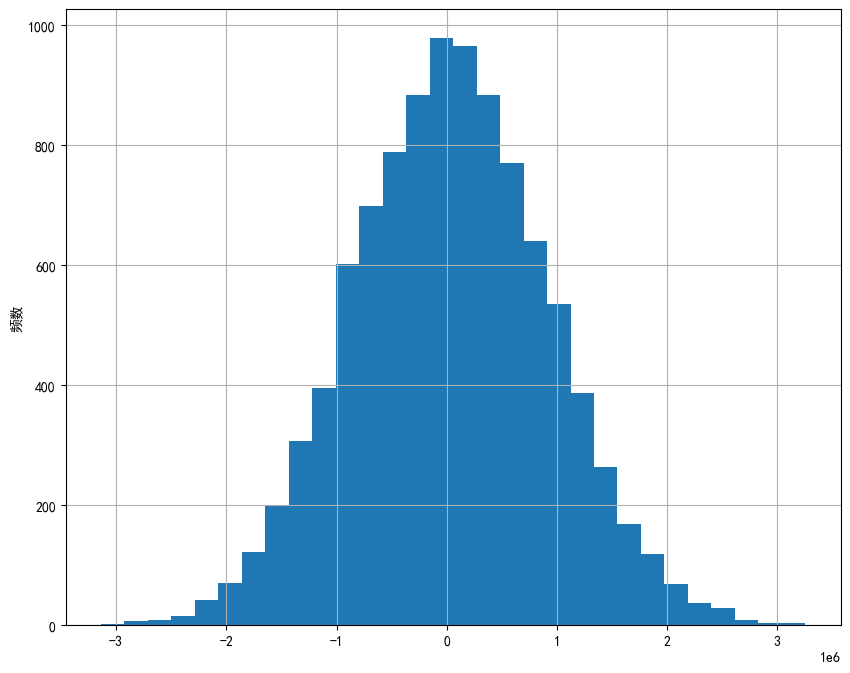

In [62]:
#服从正态分布进行模拟
epsilon_norm = npr.standard_normal(I)

S_new = np.zeros(shape=(I,len(R_mean)))

S1_new = S1*np.exp((R_mean[0]-0.5*R_vol[0]**2)*dt + R_vol[0]*epsilon*np.sqrt(dt))

for i in range(len(R_mean)):
    S_new[:,i] = data.iloc[-1,i]*np.exp((R_mean[i]-0.5*R_vol[i]**2)*dt + R_vol[i]*epsilon_norm*np.sqrt(dt))
    
S = np.array(data.iloc[-1])

Sp_delta_norm = (np.dot(S_new/S-1,weights))*value_port


plt.figure(figsize=(10,8))
plt.hist(Sp_delta_norm,bins=30)
plt.ylabel('频数')
plt.grid(True)

VaR99_1day_MSnorm = np.abs(np.percentile(a=Sp_delta_norm,q=(1-X1)*100))    
VaR95_1day_MSnorm = np.abs(np.percentile(a=Sp_delta_norm,q=(1-X2)*100))

VaR99_10day_MSnorm = np.sqrt(10)*VaR99_1day_MSnorm
VaR95_10day_MSnorm = np.sqrt(10)*VaR95_1day_MSnorm

print('1天、99%的VaR:',VaR99_1day_MSnorm)
print('10天、99%的VaR:',VaR99_10day_MSnorm)  
print('1天、95%的VaR:',VaR95_1day_MSnorm)
print('10天、95%的VaR:',VaR95_10day_MSnorm) 


### 回溯检验

2015年超出风险天数： 22
2015年超出风险天数在全年的占比： 0.09053497942386832
2016年超出风险天数： 9
2016年超出风险天数在全年的占比： 0.036885245901639344
2017年超出风险天数： 1
2017年超出风险天数在全年的占比： 0.004098360655737705
2018年超出风险天数： 6
2018年超出风险天数在全年的占比： 0.024691358024691357


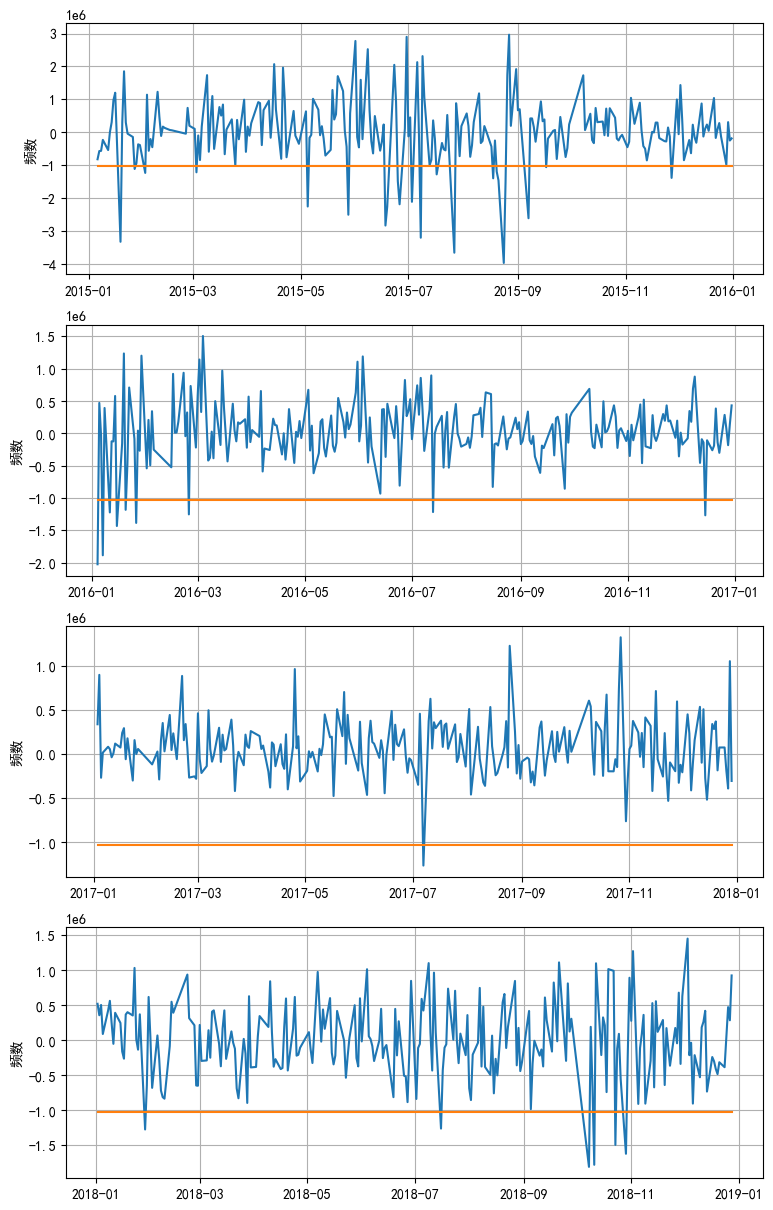

In [63]:
#回溯检测
Return_2015 = Return_history.loc['2015-01-01':'2015-12-31']
Return_2016 = Return_history.loc['2016-01-01':'2016-12-31']
Return_2017 = Return_history.loc['2017-01-01':'2017-12-31']
Return_2018 = Return_history.loc['2018-01-01':'2018-12-31']

days_2015 = len(Return_2015)
days_2016 = len(Return_2016)
days_2017 = len(Return_2017)
days_2018 = len(Return_2018)

VaR_2015 = pd.DataFrame(-VaR95_1day_VCM*np.ones_like(Return_2015),index=Return_2015.index)
VaR_2016 = pd.DataFrame(-VaR95_1day_VCM*np.ones_like(Return_2016),index=Return_2016.index)
VaR_2017 = pd.DataFrame(-VaR95_1day_VCM*np.ones_like(Return_2017),index=Return_2017.index)
VaR_2018 = pd.DataFrame(-VaR95_1day_VCM*np.ones_like(Return_2018),index=Return_2018.index)


plt.figure(figsize=(9,15))
plt.subplot(4,1,1)
plt.plot(Return_2015)
plt.plot(VaR_2015)
plt.ylabel('频数')
plt.grid(True)

plt.subplot(4,1,2)
plt.plot(Return_2016)
plt.plot(VaR_2016)
plt.ylabel('频数')
plt.grid(True)

plt.subplot(4,1,3)
plt.plot(Return_2017)
plt.plot(VaR_2017)
plt.ylabel('频数')
plt.grid(True)

plt.subplot(4,1,4)
plt.plot(Return_2018)
plt.plot(VaR_2018)
plt.ylabel('频数')
plt.grid(True)

#计算超出VaR的天数
dayexcept_2015 = len(Return_2015[Return_2015['投资组合模拟日收益']<-VaR95_1day_VCM])
dayexcept_2016 = len(Return_2016[Return_2016['投资组合模拟日收益']<-VaR95_1day_VCM])
dayexcept_2017 = len(Return_2017[Return_2017['投资组合模拟日收益']<-VaR95_1day_VCM])
dayexcept_2018 = len(Return_2018[Return_2018['投资组合模拟日收益']<-VaR95_1day_VCM])    

print('2015年超出风险天数：',dayexcept_2015)
print('2015年超出风险天数在全年的占比：',dayexcept_2015/days_2015)

print('2016年超出风险天数：',dayexcept_2016)
print('2016年超出风险天数在全年的占比：',dayexcept_2016/days_2016)

print('2017年超出风险天数：',dayexcept_2017)
print('2017年超出风险天数在全年的占比：',dayexcept_2017/days_2017)

print('2018年超出风险天数：',dayexcept_2018)
print('2018年超出风险天数在全年的占比：',dayexcept_2018/days_2018)


### 压力VaR

1天、99%的VaR: 3485224.211656878
10天、99%的VaR: 11021246.665200496
1天、95%的VaR: 2119163.2821272104
10天、95%的VaR: 6701382.705319978


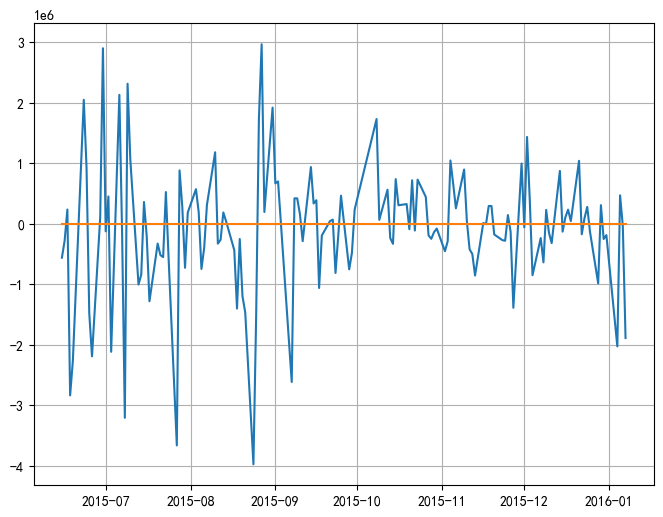

In [64]:
#压力测试
return_stress = Return_history.loc['2015-06-15':'2016-01-07']

return_stress.describe()

return_zero = pd.DataFrame(np.zeros_like(return_stress),index = return_stress.index)

#投资组合盈亏与0的可视化比较
plt.figure(figsize=(8,6))
plt.plot(return_stress)
plt.plot(return_zero)
plt.grid(True)


SVaR99_1day = np.abs(np.percentile(a=return_stress,q=(1-X1)*100))    
SVaR95_1day = np.abs(np.percentile(a=return_stress,q=(1-X2)*100)) 

SVaR99_10day = np.sqrt(10)*SVaR99_1day
SVaR95_10day = np.sqrt(10)*SVaR95_1day

print('1天、99%的VaR:',SVaR99_1day)
print('10天、99%的VaR:',SVaR99_10day)  
print('1天、95%的VaR:',SVaR95_1day)
print('10天、95%的VaR:',SVaR95_10day) 
